# Test 7: Cholesky Assembly for increasing number of regressors

This test captures the runtime for the Assembly, which is done prior to the Cholesky decomposition, with GPRat on the CPU and GPU.
We use a fixed problem size of $32768=2^{15}$, an increasing number of tiles in $\{1,2,4,8,16,32,64,128,256,512\}$, a fixed number of cores of $48$, an increasing number of regressors in $\{X,Y\}$, a fixed number of CUDA streams of XY, and loop 11 times (first loop is ignored of warmup).

Findings:

- ...

In [1]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
from scipy.stats.distributions import chi2
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams.update({"font.size": 11})
mpl.rcParams.update({"errorbar.capsize": 5})
mpl.rcParams.update({"grid.linewidth": 0.5})

In [2]:
# load data

apex_dir_assembly = "./data/7/"
subdirs = ["apex-cpu/", "apex-gpu/"]

names_assembly = [
    "cholesky_step assembly",
    "assemble K_tiles"
]

file_headers_cpu = ["n_cores", "n_train", "n_tiles", "n_reg", "n_loops"]

file_headers_gpu = ["n_cores", "n_train", "n_tiles", "n_reg", "n_streams", "n_loops"]

def apex_files_to_df(dir, names, file_headers):
    data = []
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            parts = (
                filename.replace("apex_profiles_", "").replace(".csv", "").split("_")
            )
            file_params = dict(zip(file_headers, map(int, parts)))
            file_path = os.path.join(dir, filename)
            df = pd.read_csv(file_path)
            df = df[df["name"].isin(names)]
            for key, value in file_params.items():
                df[key] = value
            data.append(df)
    df_combined = pd.concat(data, ignore_index=True)
    df_combined = df_combined.sort_values(by=["n_tiles", "n_reg"])
    return df_combined


df_assembly_cpu = apex_files_to_df(apex_dir_assembly + subdirs[0], names_assembly, file_headers_cpu)
df_assembly_gpu = apex_files_to_df(apex_dir_assembly + subdirs[1], names_assembly, file_headers_gpu)
df_assembly = [df_assembly_cpu, df_assembly_gpu]

In [3]:
def confidence_error(df, confidence=0.95, column="stddev"):
    alpha = 1.0 - confidence
    lower_limit = df[column] * np.sqrt(
        (df["n_loops"] - 1) / chi2.ppf(1 - (alpha / 2), df=(df["n_loops"] - 1))
    )
    upper_limit = df[column] * np.sqrt(
        (df["n_loops"] - 1) / chi2.ppf(alpha / 2, df=(df["n_loops"] - 1))
    )
    return [lower_limit, upper_limit]

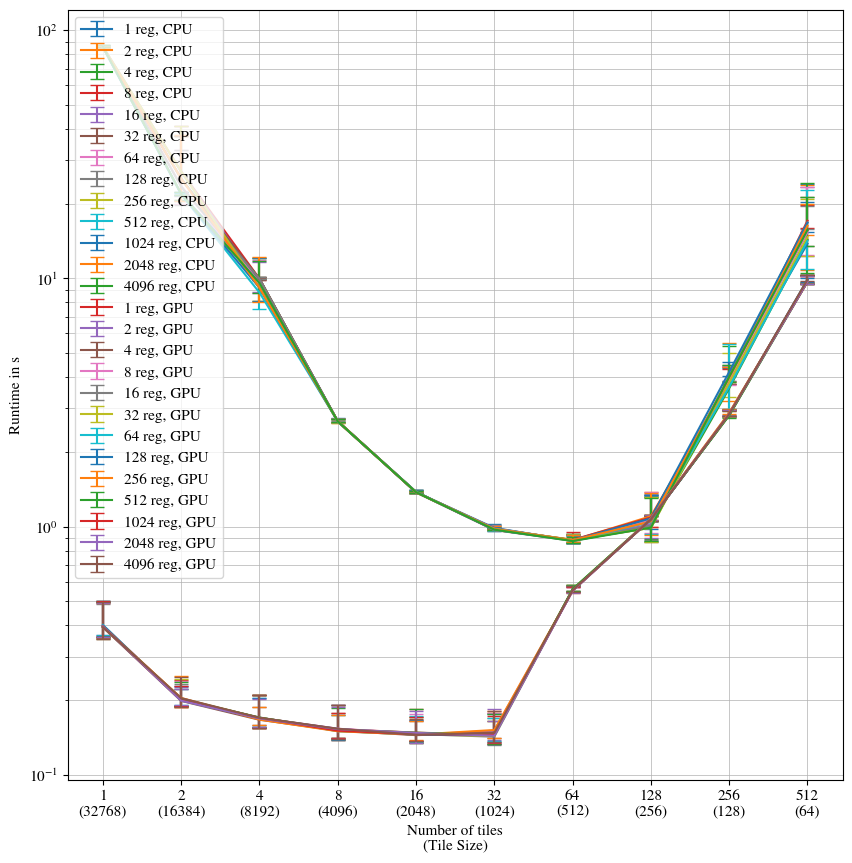

In [ ]:
# plot for assembly

n_train = 32768

plt.figure(figsize=(10, 10))

plt.xlabel('Number of tiles\n(Tile Size)')
plt.ylabel('Runtime in s')
plt.grid(True, which="both")
plt.xscale('log', base=2)
plt.yscale("log", base=10)
# plt.ylim(0.8*10**9, 10**11)

xticks = df_assembly_cpu['n_tiles'].unique()
tile_sizes = n_train / xticks
plt.xticks(
    xticks,
    [f"{int(tile)}\n({int(size)})" for tile, size in zip(xticks, tile_sizes)],
)

for df, target in zip(df_assembly, ["CPU", "GPU"]):
    for n_reg in df['n_reg'].unique():
        df_n_reg = df[(df['n_reg'] == n_reg) & (df['name'] == "cholesky_step assembly")]
        lower, upper = confidence_error(df_n_reg, 0.95)
        plt.errorbar(
            df_n_reg['n_tiles'],
            df_n_reg['mean']/10**9,
            yerr=[lower/10**9, upper/10**9],
            label=f"{n_reg} reg, {target}"
        )

plt.legend()
plt.show() # Figure is not utilized because there is no noticable difference for increasing number of regressors (up to 4096)
# plt.savefig("./pdf/cholesky-reg.pdf")